# Manual Correction of Cardiac Phase Segmentation
This script is for manually correcting the incorrect cardiac phase segmentation results which could not be corrected automatically. For the records peaks of which are incorrectly detected, detected peak indices are manually corrected by array operations such as removing entries from peak arrays or adding entries. 

The processing is as follows:
1. PCG records are loaded and chunked.
2. Chunks are normalized usng RMS normalization
3. Peak detection algorithm is performed on a record and plot is visualized.
4. If an incorrect peak is present or a peak is missing, it is manually corrected.
5. Corrected peak information is saved as a numpy file for later usage.

In [1]:
import numpy as np
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from python_speech_features import mfcc
from python_speech_features import delta
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
import scipy
from utils import *
import random
import heartpy as hp
from scipy.signal import hilbert, cheby1, filtfilt
import numpy as np
from bokeh.plotting import figure, output_file, show
import wfdb
from segmentation_utils import *


**Data Loading and RMS Normalization**

In [2]:
sampling_frequency = 2000 # in Hz
slice_length = 4          # in seconds
overlap = 2               # in seconds

normal_records, normal_records_denoised = load_records(path = '../dataset/normal_tracings.txt',normalize = False, crop = 20000)
abnormal_records, abnormal_records_denoised = load_records(path = '../dataset/abnormal_tracings.txt',normalize = False, crop = 20000)
records_train = np.concatenate((abnormal_records_denoised, normal_records_denoised), axis=0)
labels = np.concatenate((np.ones((abnormal_records_denoised.shape[0],1)),np.zeros((normal_records.shape[0],1))), axis=0)

normal_records_chunks = np.zeros((normal_records_denoised.shape[0], 4, slice_length*sampling_frequency))
slices = np.arange(0, 10, slice_length-overlap, dtype=int)
for i in range(normal_records.shape[0]):
    j = 0
    for start, end in zip(slices[:-1], slices[1:]):
        start_audio = start * sampling_frequency
        end_audio = (end + overlap)* sampling_frequency
        chunk = normal_records_denoised[i, int(start_audio): int(end_audio)]
        normal_records_chunks[i, j, :] = chunk
        j = j + 1  
        
abnormal_records_chunks = np.zeros((abnormal_records_denoised.shape[0], 4, slice_length*sampling_frequency))
for i in range(abnormal_records.shape[0]):
    j = 0
    for start, end in zip(slices[:-1], slices[1:]):
        start_audio = start * sampling_frequency
        end_audio = (end + overlap)* sampling_frequency
        chunk = abnormal_records_denoised[i, int(start_audio): int(end_audio)]
        abnormal_records_chunks[i, j, :] = chunk
        j = j + 1  

abnormal_records_chunks_reshaped = np.reshape(abnormal_records_chunks, (33*4, 8000))
normal_records_chunks_reshaped = np.reshape(normal_records_chunks, (29*4, 8000))
all_records_chunked = np.concatenate((abnormal_records_chunks_reshaped, normal_records_chunks_reshaped), axis = 0)
all_records_chunked_normalized = np.zeros_like(all_records_chunked)
labels_chunked = np.concatenate((np.ones((abnormal_records_chunks_reshaped.shape[0],1)),np.zeros((normal_records_chunks_reshaped.shape[0],1))), axis=0)


for i in range(all_records_chunked.shape[0]):
    data = all_records_chunked[i,:]
    rms_level = 0
    r = 10**(rms_level / 10.0)
    a = np.sqrt( (len(data) * r**2) / np.sum(data**2) )
    data = data * a
    all_records_chunked_normalized[i,:] = data


**Manual Correction**

chunk_index :1


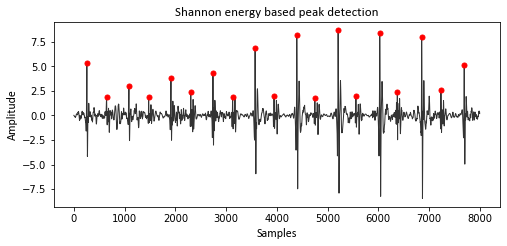

In [15]:
chunk_index = 1
print("chunk_index :" + str(chunk_index)) 

## Parameter Initialization ##
all_mean_S1 = np.zeros((all_records_chunked_normalized.shape[0],1))
all_mean_S2 = np.zeros((all_records_chunked_normalized.shape[0],1))
all_std_S1 = np.zeros((all_records_chunked_normalized.shape[0],1))
all_std_S2 = np.zeros((all_records_chunked_normalized.shape[0],1))
PCG = all_records_chunked_normalized[chunk_index,:]
sampling_rate = 2000
time_sec = np.arange(0, len(PCG)*sampling_rate)

## Peak Detection Algorithm ##
PCG_f = cheby1_bandpass_filter(PCG, lowcut=1, highcut=500, fs=sampling_rate, order=4)
dn = (np.append(PCG_f[1:], 0) - PCG_f)
dtn = dn/(np.max(abs(dn)))
an = abs(dtn)
en = an**2
sen = -abs(dtn) * np.log10(abs(dtn))
sn = -(dtn**2) * np.log10(dtn**2)
window_len = 50
sn_f = np.insert(running_mean(sn, window_len), 0, [0] * (window_len - 1))
zn = np.imag(hilbert(sn_f))
ma_len = 300
zn_ma = np.insert(running_mean(zn, ma_len), 0, [0] * (ma_len - 1))
zn_ma_s = zn - zn_ma
idx = np.argwhere(np.diff(np.sign(zn_ma_s)) > 0).flatten().tolist()
idx_search = []
id_maxes = np.empty(0, dtype=int)
search_window_half = round(sampling_rate * .15)  
for i in idx:
    lows = np.arange(i-search_window_half, i)
    highs = np.arange(i+1, i+search_window_half+1)
    if highs[-1] > len(PCG):
        highs = np.delete(highs, np.arange(np.where(highs == len(PCG))[0], len(highs)))
    PCG_window = np.concatenate((lows, [i], highs))
    idx_search.append(PCG_window)
    PCG_window_wave = PCG[PCG_window]
    id_maxes = np.append(id_maxes, PCG_window[np.where(PCG_window_wave == np.max(PCG_window_wave))[0]])

id_maxes =  id_maxes[id_maxes >= 0]
id_maxes = np.unique(id_maxes)
_, ev,od = interval(id_maxes)
min_int = np.minimum(np.mean(ev),np.mean(od))
id_maxes =  clear_adjacents(id_maxes, min_int)


## Manual numpy assignments ##
#id_maxes = np.delete(id_maxes,0)   
#id_maxes = np.delete(id_maxes,-1)  
#id_maxes = np.append(id_maxes, 3150)
#id_maxes = np.sort(id_maxes) 

_, ev,od = interval(id_maxes)
#ev = reject_outliers(ev)
#od = reject_outliers(od) 
if np.mean(ev) > np.mean(od):
    meanS2 = np.mean(ev);
    stdS2 = np.std(ev); 
    meanS1 = np.mean(od);
    stdS1 = np.std(od);
else:    
    meanS2 = np.mean(od);
    stdS2 = np.std(od);
    meanS1 = np.mean(ev);
    stdS1 = np.std(ev);

plt.figure(figsize=(8,3.4))
plt.plot(PCG, color = [0.2,0.2,0.2], linewidth=1.0)
csfont = {'fontname':'Calibri'}
plt.xlabel("Samples",fontsize = 12, **csfont)
plt.ylabel("Amplitude",fontsize = 12, **csfont)
plt.title("Shannon energy based peak detection",fontsize = 13, **csfont)
plt.plot(time_sec[id_maxes], PCG[id_maxes], "ro", markersize = 5)
values = np.stack((meanS1, meanS2, stdS1, stdS2), axis = 0)
values = np.expand_dims(values, axis = 0)


# Uncomment for saving the corrected indices
#directory = "cardiac_cycle_segmentation_features/corrected_chunks/chunk_" + str(chunk_index) + ".npy"
#np.save(directory, values)

